In [4]:
import pandas as pd
import numpy as np

import cluster as c
import decomposition as d
import decomp_clust_exp as dce

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.random_projection import GaussianRandomProjection

import matplotlib.pyplot as plt
from bokeh.plotting import output_notebook
output_notebook()
%matplotlib inline

Loading BokehJS ...

# Data

University of Wisconisn Breast Cancer Diagnosis Data Set. 30 features computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. 

569 instances, 67% benign (F), and 37% malignant (T).

In [5]:
# Wisconsin
data = pd.read_csv('data/data.csv')
data['diagnosis'] = np.where(data['diagnosis'] == 'M', 1, 0)
X = data.iloc[:, 2:]
y = data['diagnosis']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=7412)
alpha=0.0005
max_iter=270 
hls=(300, )

Kaggle Heart Failure. 12 features which asre a mix of bloof health metrics, medical conditions, and demographic data (age and gender). 

299 instances, 35% are a death event (T) and 68% are a surival event (F).

In [6]:
# Heart Failure
data = pd.read_csv('data/heart_failure_clinical_records_dataset.csv')
X = data.iloc[:,:-1]
y = data['DEATH_EVENT']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=7412)

alpha=0.0007 
max_iter=200
hls=(225, )

# Part 1 Clustering

KMeans Clustering:

KMeans is a clustering algorithm that selects n initial centroids and then iteratively adds samples to the cluster. After each addition to a cluster the centroid point in updated. The initial centroids are created using the kmean++ initialization scheme which aims to create centroids that are generally distant from one another. KMeans aims to create clusters that minimize inertia or the within-cluster sum-of-squares criterion. 
As the number of clusters increases the inertia decreases. The optimal number of clusters can be determining by finding the point of diminishing returns when comparing the inertia to the number of clusters. The goal is to select the largest “bend” in inertia. This is referred to as the elbow method.

Expectation Maximization:

Expectation Maximization is implemented using a Gaussian Mixture model. Expectation Maximization iteratively builds clusters by computing the probability of being generated by each component. The Gaussian Mixture model assumes all data points are generated from n Gaussian distributions with unknown parameters. In addition to a being a generalized k-means clustering model Gaussian Mixture takes into account the covariance structure of the data as well as the centers of the Gaussians. I used the default covariance type, ‘full’, which gives each component its own general covariance matrix.
Expectation Maximization is evaluated by looking at the Akaike Information Criterion (AIC) and the Bayesian Information Criterion (BIC). Both are a criterion for model selection using a likelihood function and include a penalty for the number of parameters in the model. The lower the criterion score the more a specific model is preferred.



Clustering Metrics:

1.	Davis Bouldin Score (dbs): The average similarity measure of each cluster to its most similar cluster. It defines similarity as the ratio of within-cluster distances to between-cluster distances. Clusters which are farther apart and less dispersed will result in a better score. The score range is [0.0, inf) where 0.0 is the minimum score and indicates the better clustering.
2.	Silhouette Score (ss): The mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The score range is [-1.0, 1.0] where -1 is the worst value and 1 is the best value.
(b – a) / max(a,b)
3.	Homogeneity Score (homo): The score measures the cluster labeling given a ground truth. If all of its clusters contain only data points which are members of a single class, then the result satisfies homogeneity. The score range is [0.0, 1.0] where 1.0 is a perfectly homogeneous labeling. Homogeneity looks at the classes assigned to a cluster
4.	Completeness Score (comp): The score also measures the cluster labeling given a ground truth. If all the data points that are members of a given class are elements of the same cluster, then the result satisfies completeness. The score range is [0.0, 1.0] where 1.0 is a perfectly complete labeling. Completeness score looks at clusters a class is assigned to.


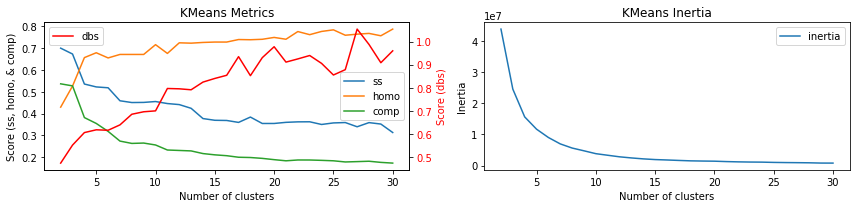

In [6]:
met = c.evaulate_kmeans(X_train, X_test, y_train, y_test, n_min=2, n_max=len(X_train.columns.values))
c.plot_kmeans_metrics(df=met, save=False, show=True)

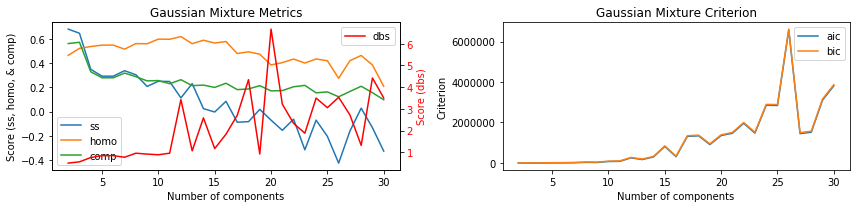

In [7]:
met = c.evaulate_gaussian_mixture(X_train, X_test, y_train, y_test, n_min=2, n_max=len(X_train.columns.values))
c.plot_gaussian_mixture_metrics(df=met, save=False, show=True)

Quick PCA Visualization:

Quick visualization utilizing the 1st 2 prinicipal component. Can intuitively be understood as a reduction of all features down to 2.

The 1st chart is the data labels, the 2nd chart is the 2Means clusters, and the 3rd chart is 2Gaussian Mixture clusters. The aim is to see data labels that are linearly seperable by a principle component in the 1st chart and similarly sperable data in the 2nd and 3rd chart. 

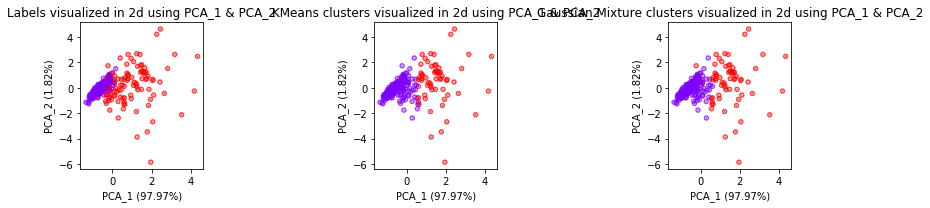

In [8]:
c.plot_clusters_PCA(X_train, X_test, y_test, save=False, show=True)

# Part 2: Decomp

Principal Component Analysis (PCA):

PCA decomposes a dataset into orthogonal components that maximize the amount of variance. The goal is to project the dataset's variance onto a smallers feature set. By analyzing the explained variance of each decomposed component, a smaller feature set can be created. The value of the components can be determined by looking at the eigenvalues or explained variance of each component.

Independed Component Analysis (ICA):

ICA is implemented using FastICA. ICA decomposes a dataset into additive subcomponents that are maximally independent. ICA is dependent upon the indenpendent signals it is trying to identify not being Gaussian. If the signals are Gaussian, then ICA cannot resolve the independence of the signals due to symmetries.

ICA maximizes independence by maximizing the non-Gaussianity or the kurtosis of the components. Kurtosis is the 4th moment of Gaussian Distribution. It measures the “peakedness” or “flatness” of a distribution relative to the normal distribution. A “flat” distribution has negative kurtosis and a “spikey” distribution has positive kurtosis. ICA performs best when the data is preprocessed to be centered and whitened. Centering involves placing the mean at the center of each attribute by subtracting the mean from each feature. Whitening involves apply a linear transformation to confirm all attributes are uncorrelated and have unit variance.
You can analyze each decomposed component by measuring its kurtosis. Measuring kurtosis is different from measuring the variance of a component. You cannot measure the variance of an independent component because its variance is assumed to be unit.


Truncated Singular Value Decomposition (tSVD):

tSVD is very similar to PCA. In fact, SVD is used to calculate the principal components in PCA. tSVD differs by not centering the input matrix X. It maintains the global structure of the input. If the data is highly informative towards the extreme values of the input attributes, then centering the data can remove value.

Variance can be used to explain the value of each decomposed component. By comparing the PCA components to the tSVD components we can determine how informative the input is towards the extreme values

Randomized Projection (GRP):

Randomized Projection is implemented using Gaussian Random Projection (GRP). Gaussian random projection reduces dimensionality by projecting the original input space on a randomly generated matrix where the components are drawn from a normal distribution relative to the number of components.

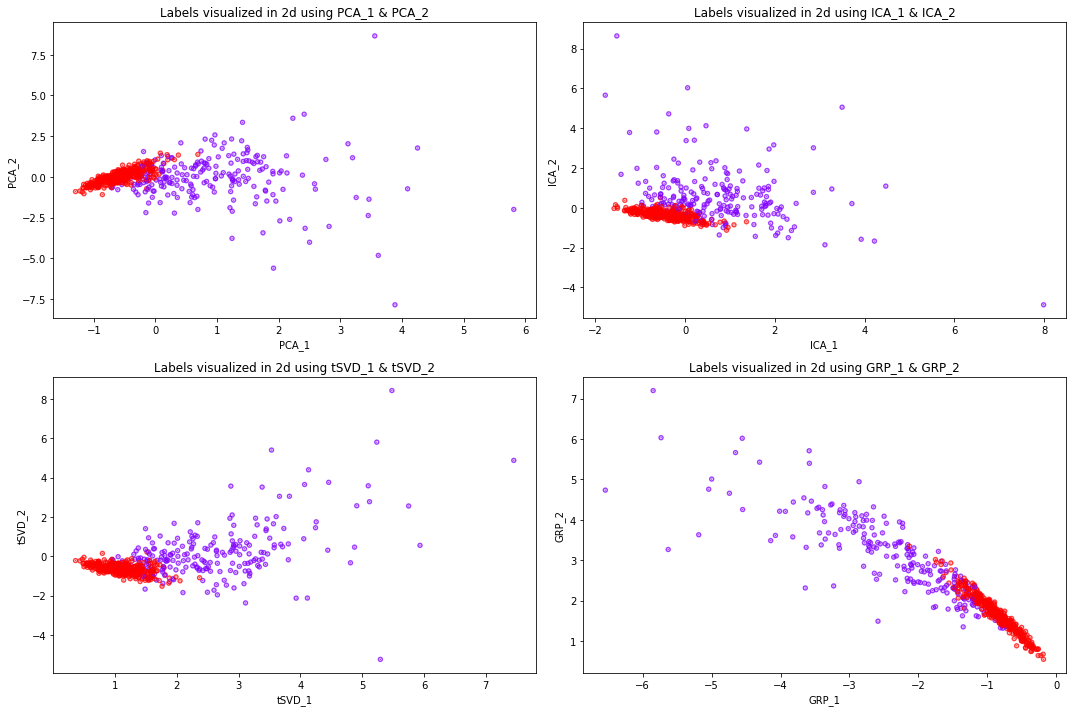

In [9]:
d.quick_decomp(X, y, save=False, show=True)

In [10]:
d.compare_components(X, y, dcp='PCA', comp=4, save=False, show=True)

In [11]:
d.compare_components(X, y, dcp='tSVD', comp=4, save=False, show=True)

In [12]:
d.compare_components(X, y, dcp='ICA', comp=4, save=False, show=True)

In [28]:
d.compare_components(X, y, dcp='GRP', comp=4, save=False, show=True)


*--- PCA Report ---*

X mean:		61.891
X variance:	52119.705

...Rescaling data...

X_scaled mean:		0.000
X_scaled variance:	1.000


 -- Summary --
You can reduce from 30 to 10 dimensions while retaining 95% of variance.
2 PCA explain 63.20% of variance.
3 PCA explain 72.60% of variance.


X*X_a: (30, 569) * (569, 30) = (30, 30)


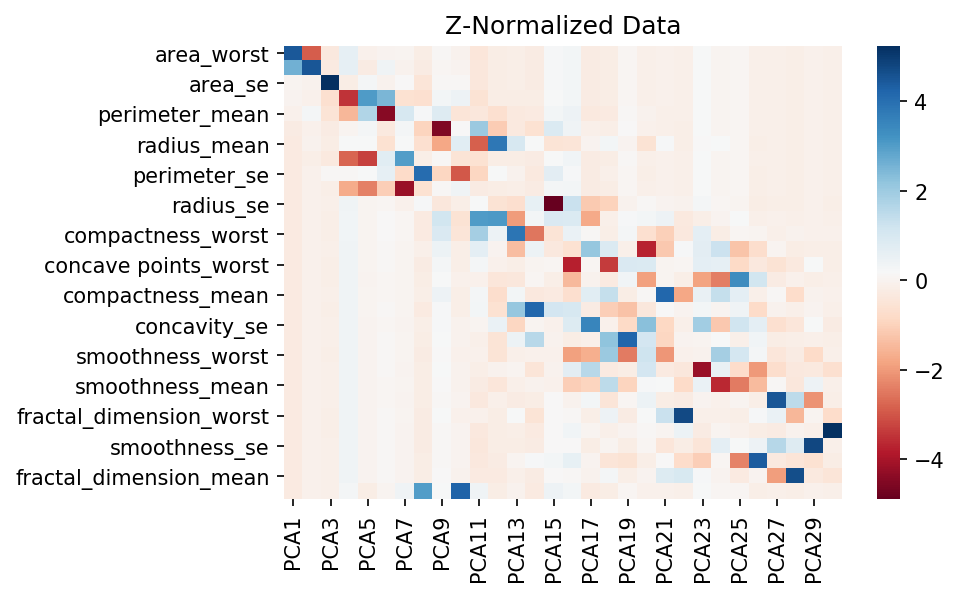

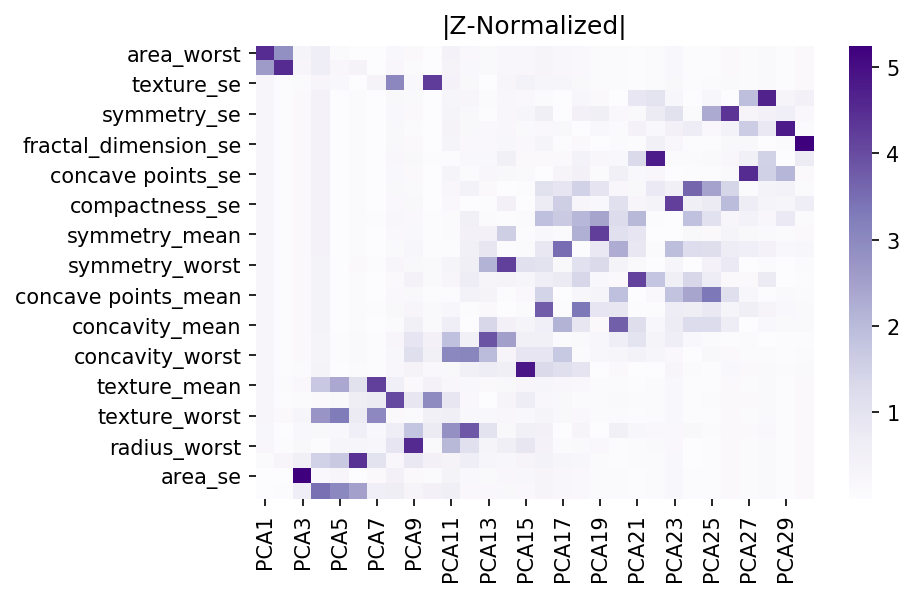

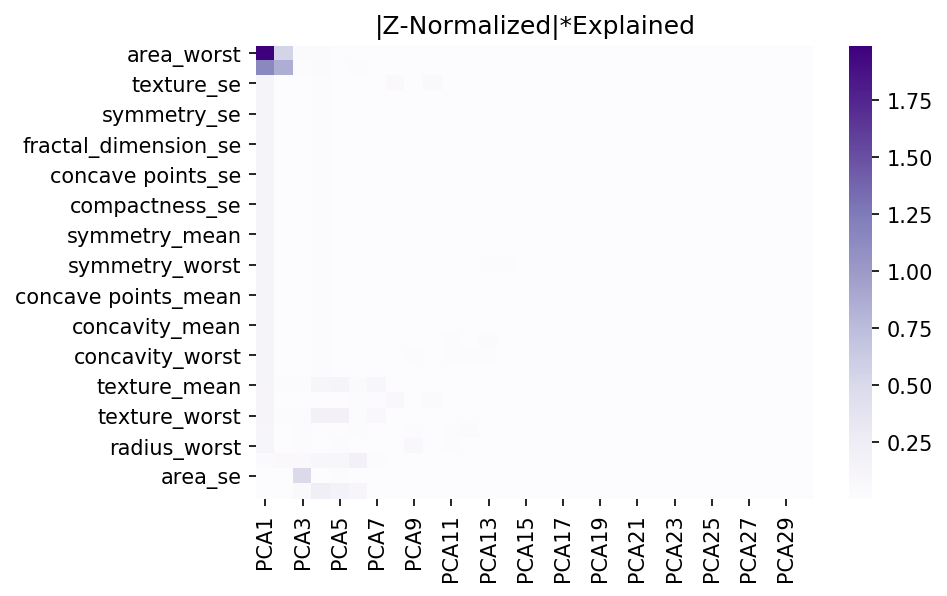

        score_                 feature_
rank                                   
1     2.632437               area_worst
2     2.130730                area_mean
3     0.658089            texture_worst
4     0.622168          perimeter_worst
5     0.573232           perimeter_mean
6     0.564049                  area_se
7     0.559287             texture_mean
8     0.333881             perimeter_se
9     0.310926              radius_mean
10    0.302672             radius_worst
11    0.300929               texture_se
12    0.298675          concavity_worst
13    0.283951        compactness_worst
14    0.256497           symmetry_worst
15    0.232107           concavity_mean
16    0.231868                radius_se
17    0.223269            symmetry_mean
18    0.223036         compactness_mean
19    0.222106             concavity_se
20    0.221988         smoothness_worst
21    0.220548     concave points_worst
22    0.213740          smoothness_mean
23    0.212692      concave points_mean


In [29]:
df_a, X_a, a_exp, df_corr, df_n, df_na, df_nabv, df_rank = d.full_report(X.to_numpy(), features_=X.columns.values, method='PCA', num_features=X.shape[1], save_plot=False)


*--- tSVD Report ---*

X mean:		61.891
X variance:	52119.705

...Rescaling data...

X_scaled mean:		0.000
X_scaled variance:	1.000


 -- Summary --
You can reduce from 29 to 10 dimensions while retaining 95% of variance.
2 tSVD explain 63.20% of variance.
3 tSVD explain 72.60% of variance.


X*X_a: (30, 569) * (569, 30) = (30, 30)


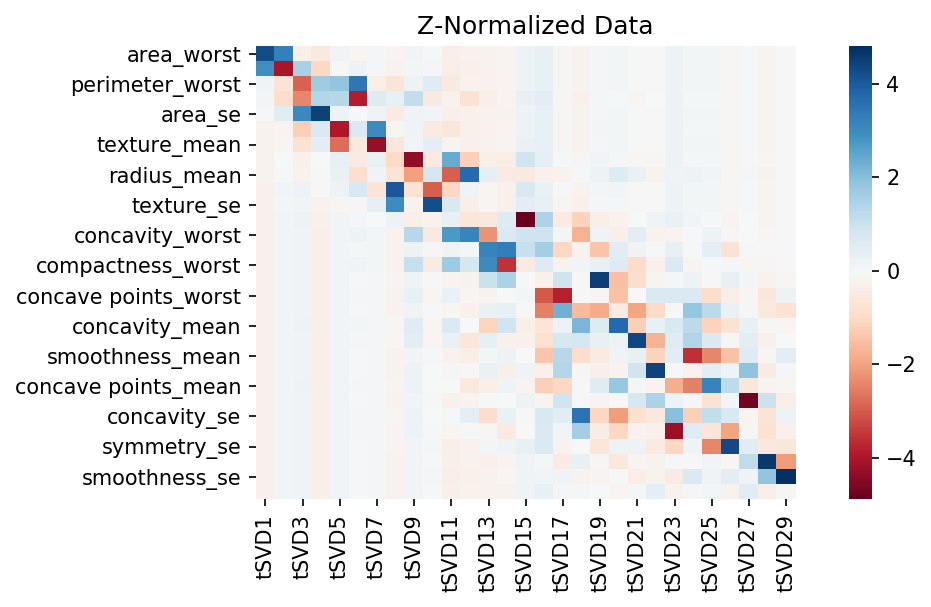

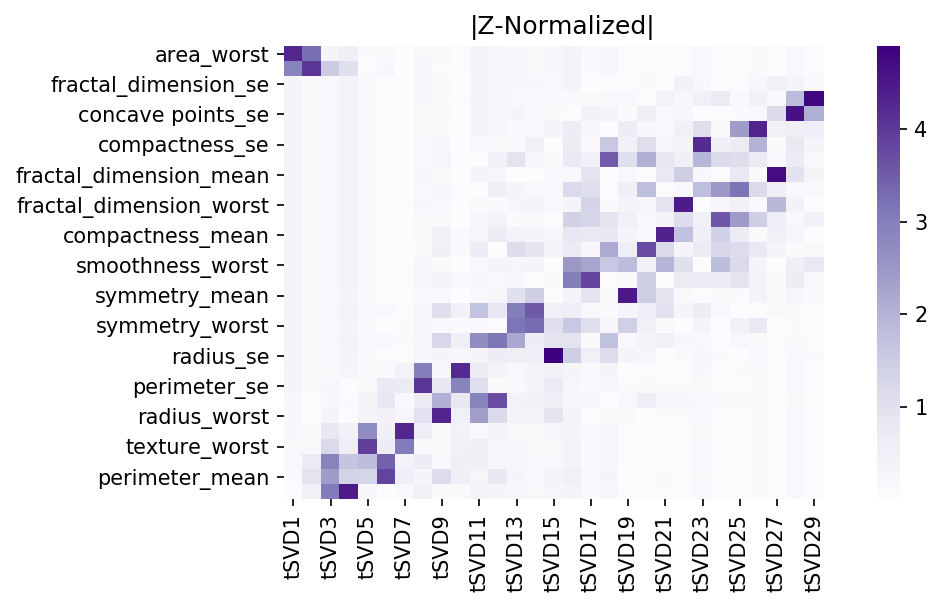

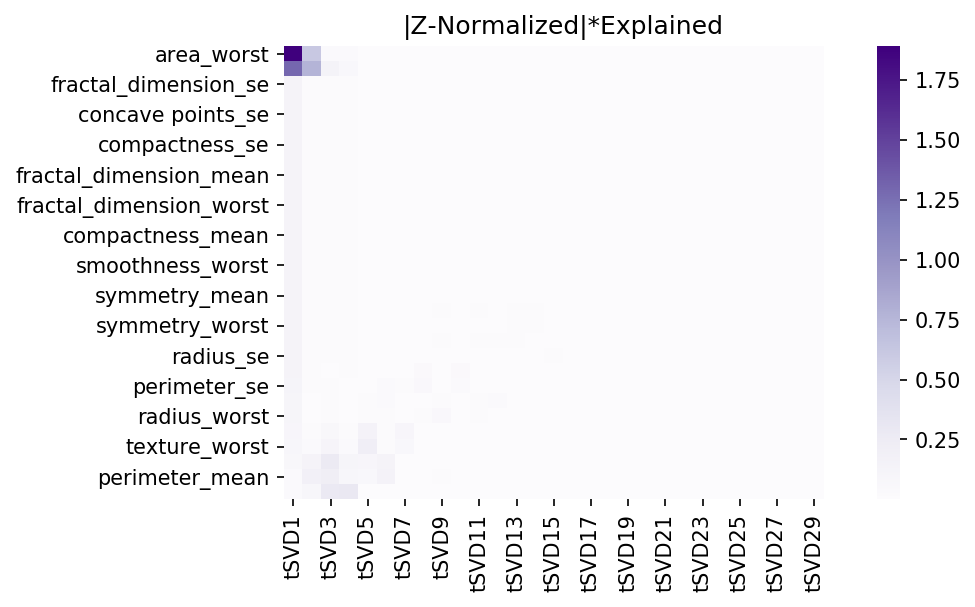

        score_                 feature_
rank                                   
1     2.598749               area_worst
2     2.307361                area_mean
3     0.875694          perimeter_worst
4     0.821924           perimeter_mean
5     0.746889                  area_se
6     0.622212            texture_worst
7     0.529249             texture_mean
8     0.362904             perimeter_se
9     0.326902          concavity_worst
10    0.322318              radius_mean
11    0.316540               texture_se
12    0.308797        compactness_worst
13    0.307503             radius_worst
14    0.272034           symmetry_worst
15    0.257031                radius_se
16    0.255897           concavity_mean
17    0.245202     concave points_worst
18    0.245053         compactness_mean
19    0.244165             concavity_se
20    0.243028            symmetry_mean
21    0.242625         smoothness_worst
22    0.237142      concave points_mean
23    0.233603          smoothness_mean


In [30]:
df_a, X_a, a_exp, df_corr, df_n, df_na, df_nabv, df_rank = d.full_report(X.to_numpy(), features_=X.columns.values, method='tSVD', num_features=X.shape[1]-1, save_plot=False)


*--- ICA Report ---*

X mean:		61.891
X variance:	52119.705

...Rescaling data...

X_scaled mean:		0.000
X_scaled variance:	1.000


 -- Summary --
You can reduce from 30 to 18 dimensions while retaining 95% of variance.
2 ICA explain 52.00% of variance.
3 ICA explain 60.00% of variance.


X*X_a: (30, 569) * (569, 30) = (30, 30)


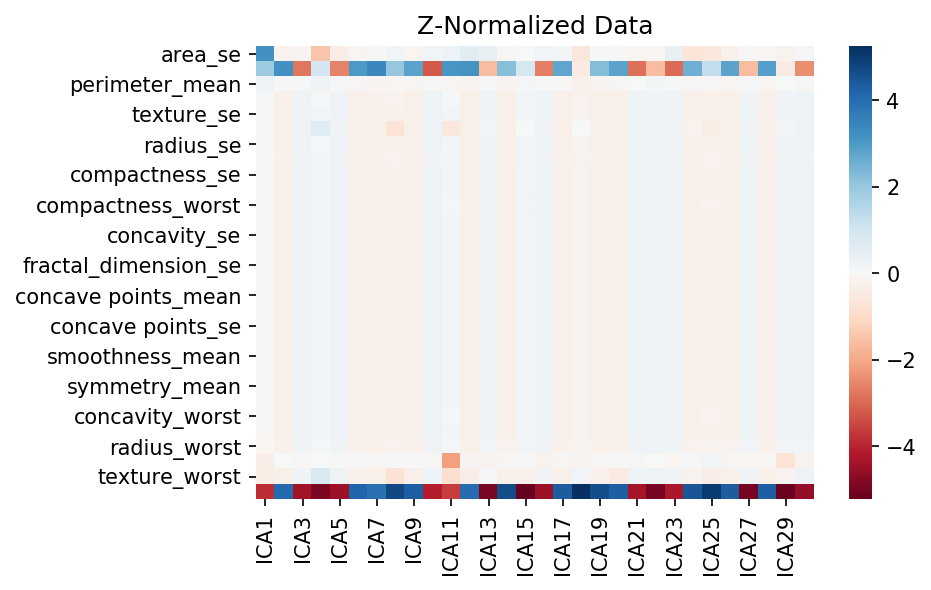

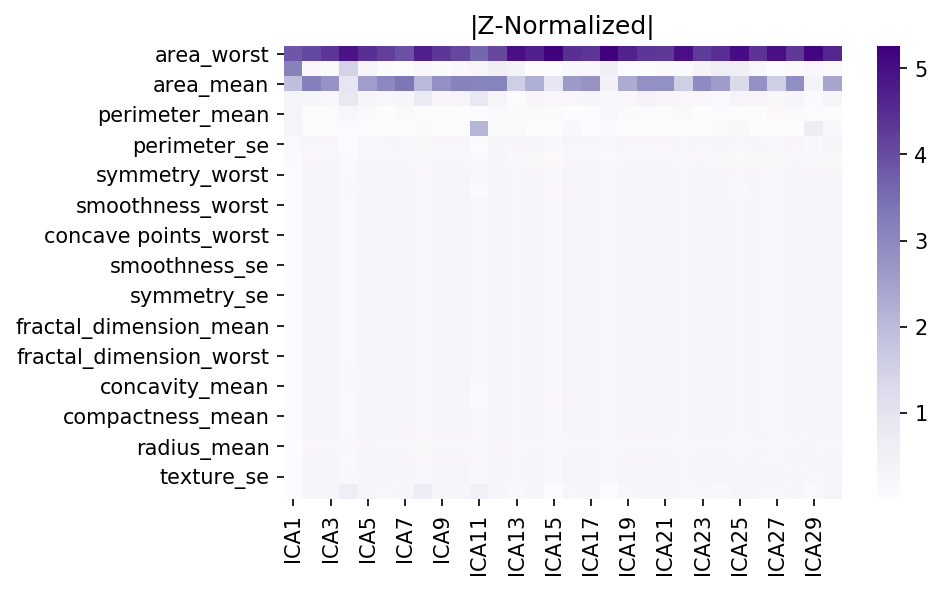

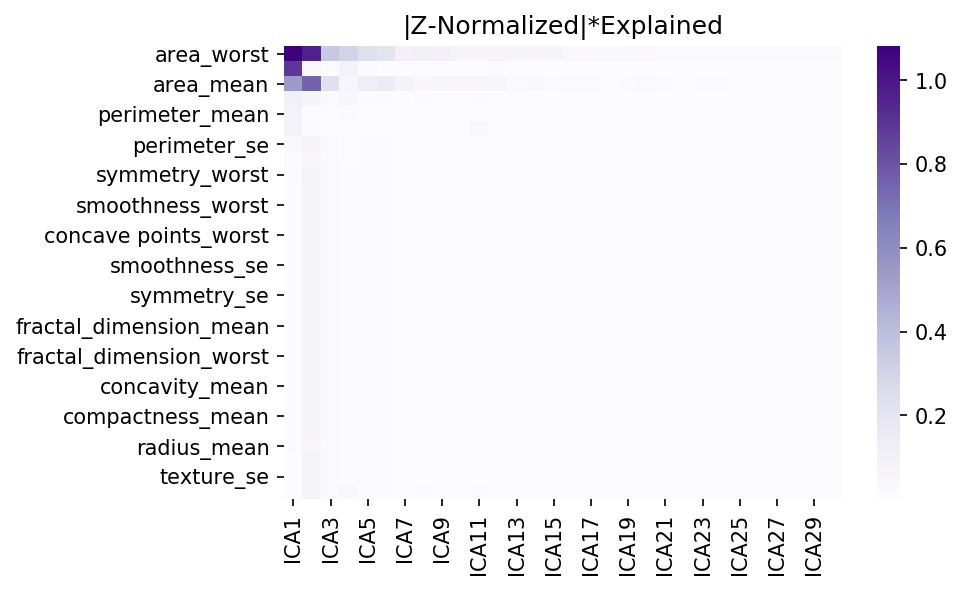

        score_                 feature_
rank                                   
1     4.199870               area_worst
2     2.461624                area_mean
3     1.106114                  area_se
4     0.357284            texture_worst
5     0.233828             texture_mean
6     0.219364             perimeter_se
7     0.211544           symmetry_worst
8     0.210411         smoothness_worst
9     0.209912            smoothness_se
10    0.209811          concavity_worst
11    0.209777          smoothness_mean
12    0.209758            symmetry_mean
13    0.209671        concave points_se
14    0.209651     concave points_worst
15    0.209604              symmetry_se
16    0.209447     fractal_dimension_se
17    0.209382   fractal_dimension_mean
18    0.209166      concave points_mean
19    0.209150             concavity_se
20    0.209041  fractal_dimension_worst
21    0.208294           concavity_mean
22    0.207732           compactness_se
23    0.207260         compactness_mean


In [31]:
df_a, X_a, a_exp, df_corr, df_n, df_na, df_nabv, df_rank = d.full_report(X.to_numpy(), features_=X.columns.values, method='ICA', num_features=X.shape[1], save_plot=False)


*--- GRP Report ---*

X mean:		61.891
X variance:	52119.705

...Rescaling data...

X_scaled mean:		0.000
X_scaled variance:	1.000


 -- Summary --
You can reduce from 30 to 27 dimensions while retaining 95% of variance.
2 GRP explain 29.00% of variance.
3 GRP explain 34.00% of variance.


X*X_a: (30, 569) * (569, 30) = (30, 30)


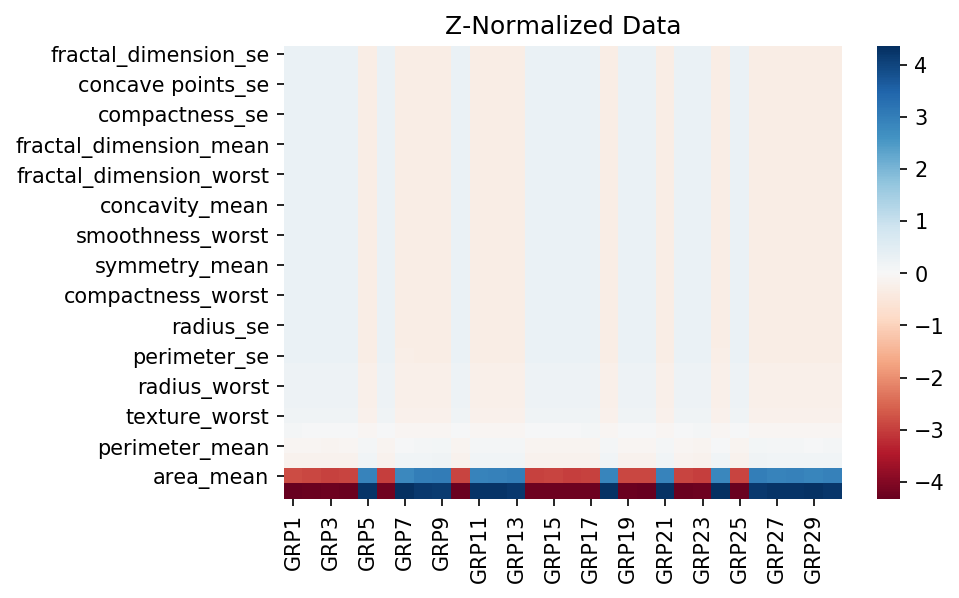

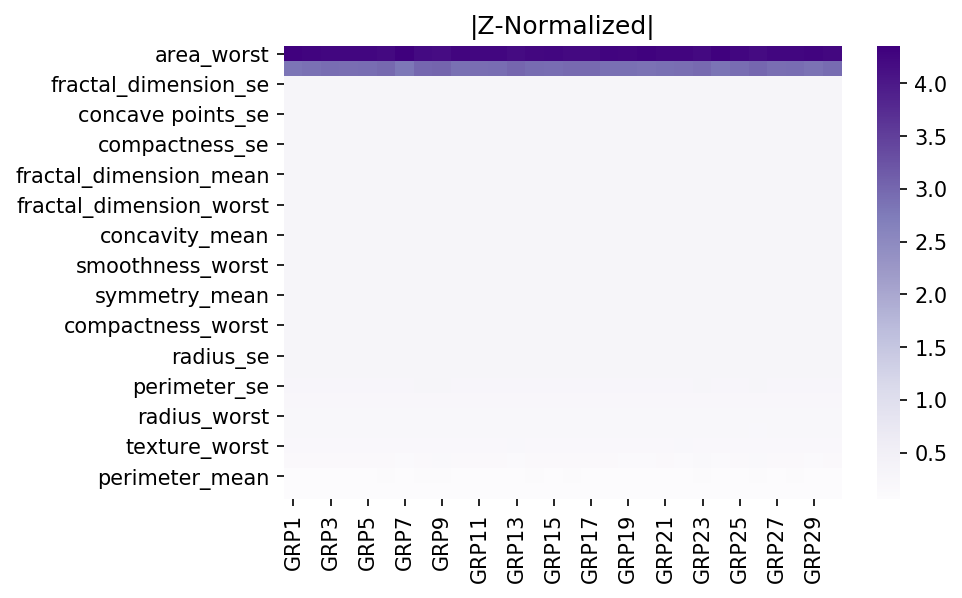

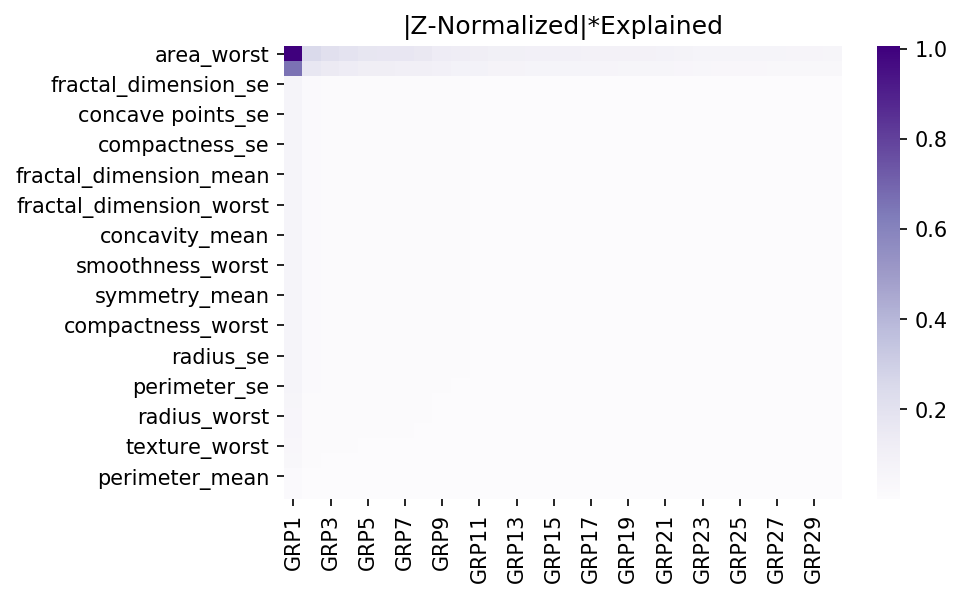

        score_                 feature_
rank                                   
1     4.276870               area_worst
2     2.909836                area_mean
3     0.308258     fractal_dimension_se
4     0.308247            smoothness_se
5     0.308223        concave points_se
6     0.308197              symmetry_se
7     0.308169           compactness_se
8     0.308140             concavity_se
9     0.308040   fractal_dimension_mean
10    0.308018      concave points_mean
11    0.307953  fractal_dimension_worst
12    0.307903          smoothness_mean
13    0.307819         compactness_mean
14    0.307819           concavity_mean
15    0.307763         smoothness_worst
16    0.307730     concave points_worst
17    0.307579            symmetry_mean
18    0.307159        compactness_worst
19    0.307149           symmetry_worst
20    0.306993          concavity_worst
21    0.306296                radius_se
22    0.303822               texture_se
23    0.294290             perimeter_se


In [32]:
df_a, X_a, a_exp, df_corr, df_n, df_na, df_nabv, df_rank = d.full_report(X.to_numpy(), features_=X.columns.values, method='GRP', num_features=X.shape[1], save_plot=False)

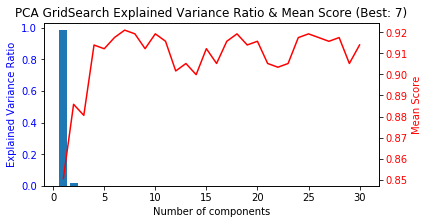

In [33]:
PCA_best = d.gridsearch(X, y, dcp='PCA', comp=X.shape[1], show=True, save=False)

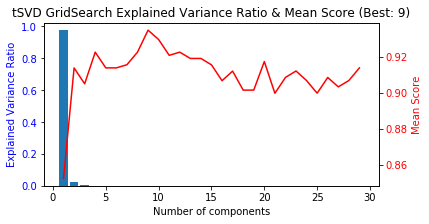

In [34]:
tSVD_best = d.gridsearch(X, y, dcp='tSVD', comp=X.shape[1]-1, show=True, save=False)

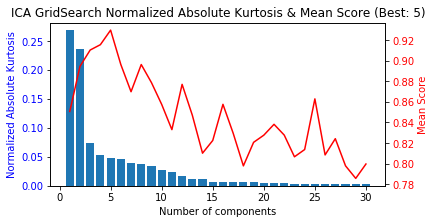

In [35]:
ICA_best = d.gridsearch(X, y, dcp='ICA', comp=X.shape[1], rs=1399, show=True, save=False)

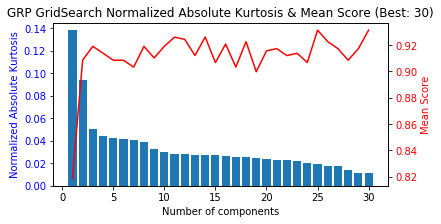

In [36]:
GRP_best = d.gridsearch(X, y, dcp='GRP', comp=X.shape[1], show=True, save=False)

In [37]:
print('PCA: {pca}'.format(pca=PCA_best))
print('tSVD: {tsvd}'.format(tsvd=tSVD_best))
print('ICA: {ica}'.format(ica=ICA_best))
print('GRP: {grp}'.format(grp=GRP_best))

PCA: 7
tSVD: 9
ICA: 5
GRP: 30


# Part 3: Decomp Clusters

In [38]:
pca_ = PCA(n_components=PCA_best).fit(X)
pca_X_train = pca_.transform(X_train)
pca_X_test = pca_.transform(X_test)

tsvd_ = TruncatedSVD(n_components=tSVD_best).fit(X)
tsvd_X_train = tsvd_.transform(X_train)
tsvd_X_test = tsvd_.transform(X_test)

ica_ = FastICA(random_state=1399, n_components=ICA_best).fit(X)
ica_X_train = ica_.transform(X_train)
ica_X_test = ica_.transform(X_test)

grp_ = GaussianRandomProjection(random_state=1399, n_components=GRP_best).fit(X)
grp_X_train = grp_.transform(X_train)
grp_X_test = grp_.transform(X_test)

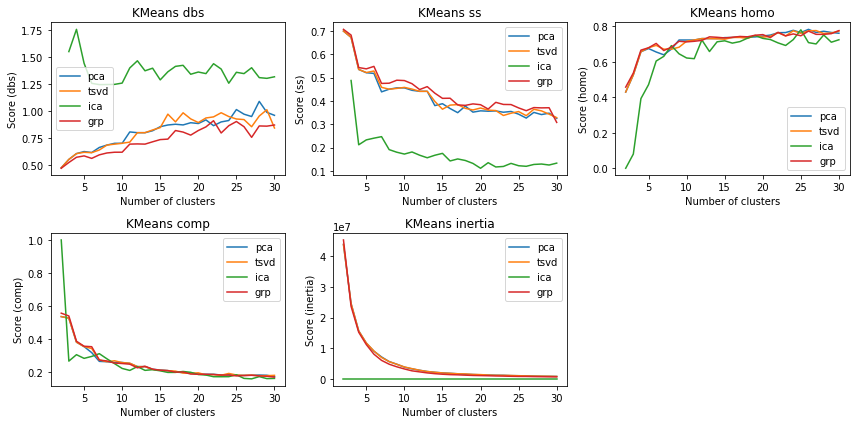

In [39]:
pca_kmeans_df = c.evaulate_kmeans(pca_X_train, 
                             pca_X_test, 
                             y_train, 
                             y_test, 
                             n_min=2, 
                             n_max=len(X_train.columns.values))

tsvd_kmeans_df = c.evaulate_kmeans(tsvd_X_train, 
                             tsvd_X_test, 
                             y_train, 
                             y_test, 
                             n_min=2, 
                             n_max=len(X_train.columns.values))

ica_kmeans_df = c.evaulate_kmeans(ica_X_train, 
                             ica_X_test, 
                             y_train, 
                             y_test, 
                             n_min=2, 
                             n_max=len(X_train.columns.values))

grp_kmeans_df = c.evaulate_kmeans(grp_X_train, 
                             grp_X_test, 
                             y_train, 
                             y_test, 
                             n_min=2, 
                             n_max=len(X_train.columns.values))

dce.plot_clust_metrics(dfs=[pca_kmeans_df, tsvd_kmeans_df, ica_kmeans_df, grp_kmeans_df],
                       clust_m='KMeans',
                       save=False,
                       show=True)

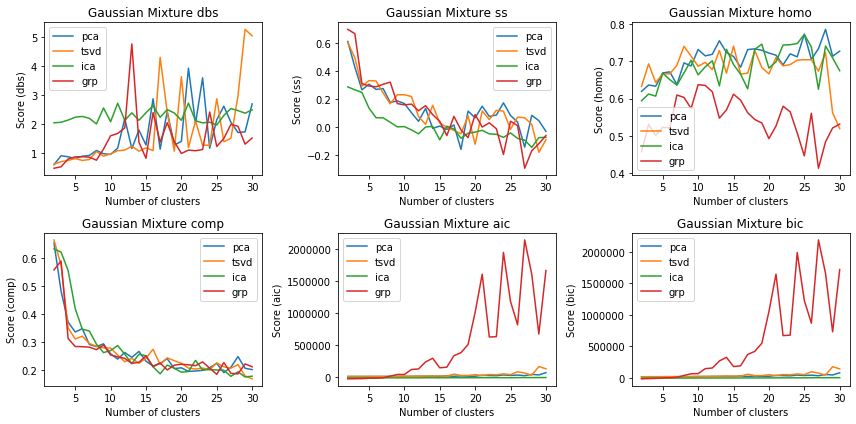

In [40]:
pca_gm_df = c.evaulate_gaussian_mixture(pca_X_train, 
                             pca_X_test, 
                             y_train, 
                             y_test, 
                             n_min=2, 
                             n_max=len(X_train.columns.values))

tsvd_gm_df = c.evaulate_gaussian_mixture(tsvd_X_train, 
                             tsvd_X_test, 
                             y_train, 
                             y_test, 
                             n_min=2, 
                             n_max=len(X_train.columns.values))

ica_gm_df = c.evaulate_gaussian_mixture(ica_X_train, 
                             ica_X_test, 
                             y_train, 
                             y_test, 
                             n_min=2, 
                             n_max=len(X_train.columns.values))

grp_gm_df = c.evaulate_gaussian_mixture(grp_X_train, 
                             grp_X_test, 
                             y_train, 
                             y_test, 
                             n_min=2, 
                             n_max=len(X_train.columns.values))

dce.plot_clust_metrics(dfs=[pca_gm_df, tsvd_gm_df, ica_gm_df, grp_gm_df],
                       clust_m='Gaussian Mixture',
                       save=False,
                       show=True)

# Part 4: NN

In [41]:
train_df, test_df = dce.gen_nn_decomp_error(X, X_train, X_test, y_train, y_test, 
                        n_min=2, n_max=X.shape[1]-1, 
                        alpha=alpha, max_iter=max_iter, hls=hls)

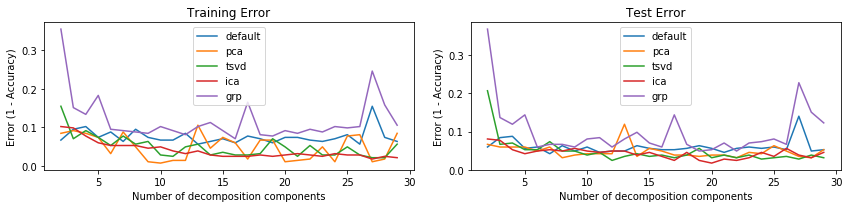

In [42]:
x_label = 'Number of decomposition components'
experiment = 'decomp_nn_error'
lines=['default', 'pca', 'tsvd', 'ica', 'grp']


dce.plot_train_test(train_df, test_df, 
                x_label=x_label, lines=lines, 
                experiment=experiment, 
                save=False, show=True)


# Part 5

In [43]:
best = [PCA_best, tSVD_best, ICA_best, GRP_best]
n_min=2
n_max=X.shape[1]
clust_m='KMeans'

train_df, test_df = dce.gen_nn_decomp_clust_error(X, X_train, X_test, y_train, y_test,
                              best=best, clust_m=clust_m,
                            n_min=2, n_max=X.shape[1],
                            alpha=alpha, max_iter=max_iter, hls=hls)

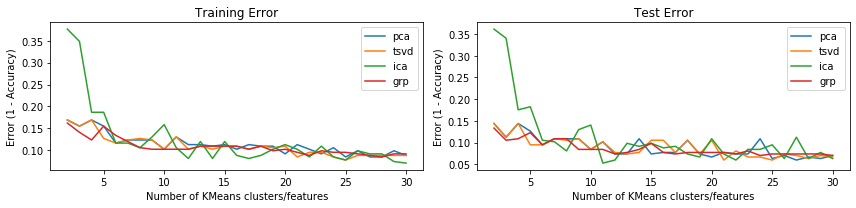

In [44]:
x_label = 'Number of {} clusters/features'.format(clust_m)
experiment = 'decomp_kmeans_clust_nn_error'
lines=['pca', 'tsvd', 'ica', 'grp']


dce.plot_train_test(train_df, test_df, 
                x_label=x_label, lines=lines, 
                experiment=experiment, 
                save=False, show=True)

In [27]:
best = [PCA_best, tSVD_best, ICA_best, GRP_best]
n_min=2
n_max=X.shape[1]
clust_m='Gaussian Mixture'

train_df, test_df = dce.gen_nn_decomp_clust_error(X, X_train, X_test, y_train, y_test,
                              best=best, clust_m=clust_m,
                            n_min=2, n_max=X.shape[1],
                            alpha=alpha, max_iter=max_iter, hls=hls)

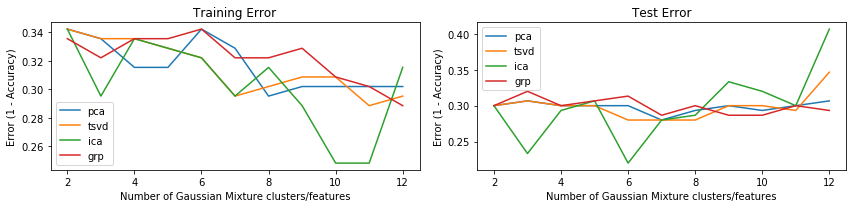

In [32]:
x_label = 'Number of {} clusters/features'.format(clust_m)
experiment = 'decomp_gm_clust_nn_error'
lines=['pca', 'tsvd', 'ica', 'grp']


dce.plot_train_test(train_df, test_df, 
                x_label=x_label, lines=lines, 
                experiment=experiment, 
                save=False, show=True)